### **本节将前面神经网络的理论进行应用**

**新内容：误差反向传播法快速计算梯度**

回顾一下学习算法的**基本流程**为： 

**前提**  
神经网络存在合适的权重和偏置，**调整权重和偏置**以便拟合训练数据的  
过程称为“学习”。神经网络的学习分成下面**4个步骤**。  

**步骤1（mini-batch）**  
(推荐自己框架的所有函数应该兼容批处理)  
从训练数据中随机选出一部分数据，这部分数据称为**mini-batch**。我们  
的目标是**减小mini-batch的损失函数的值**。

**步骤2（计算梯度）**  
为了减小mini-batch的损失函数的值，需要求出各个权重参数的梯度。
梯度表示损失函数的值减小最多的方向。

**步骤3（更新参数）**  
将权重参数沿梯度方向进行微小更新

**步骤4（重复）**  
重复步骤1、步骤2、步骤3

***

**下面开始实现改进的神经学习网络**

In [2]:
# 导入必要的包
import numpy as np
import my_frame as mf # 导入框架
import gradient as gd
from collections import OrderedDict # 导入记忆顺序的字典

In [3]:
# 构建改进的两层神经网络
class TwoLayerNet:
    """改进两层神经网络"""

    def __init__(self,input_size,hidden_size,output_size,
                 weight_init_std = 0.01):
        """神经网络初始化,weight_init_std为我目前未知参数"""
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std* \
            np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std* \
            np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            mf.Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu1'] = mf.Relu() # 这里与之前的神经网络sigmoid不同，这里用relu
        self.layers['Affine2'] = \
            mf.Affine(self.params['W2'],self.params['b2'])
        
        self.lastLayer = mf.SoftmaxWithLoss()

    def predict(self,x):
        """神经网络的推理过程; x为输入矩阵"""
        for layer in self.layers.values(): # 顺序执行计算图中的节点
            x = layer.forward(x)

        return x
    
    def loss(self,x,t):
        """神经网络的损失函数计算;x为输入矩阵,t为监督数据矩阵"""
        y = self.predict(x)
        return self.lastLayer.forward(y,t)
    
    def accuracy(self,x,t):
        """估计识别精度;x为输入矩阵,t为监督数据矩阵(兼容one_hot与非one_hot)"""
        y = self.predict(x)
        y = np.argmax(y,axis = 1)

        if t.size != y.size:
            t = np.argmax(t,axis = 1)

        return np.sum(y == t)/float(x.shape[0])
    
    def numerical_gradient(self,x,t):
        """基于数值微分的梯度计算,主要用于确定误差反向传播的正确性;x为输入矩阵,t为监督数据"""

        # 定义兼容函数
        loss_W = lambda W:self.loss(x,t)

        grads = {}
        grads['W1'] = mf.numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = mf.numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = mf.numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = mf.numerical_gradient(loss_W,self.params['b2'])

        return grads
    
    def gradient(self,x,t):
        """基于误差反向传播的梯度计算,快速计算梯度;x为输入矩阵,t为监督数据"""

        # forward前向传播处理
        self.loss(x,t)

        # backward反向传播计算梯度
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 保存梯度
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads


        

**注意**：  

将神经网络的层保存为OrderedDict这一点非常重要。  
OrderedDict是**有序字典**，“有序”是指它可以**记住向字典里添加元素的顺序**。  
因此，神经网络的正向传播只需**按照添加元素的顺序调用**各层的forward()方法就可以完成处理。  
而反向传播只需要**按照相反的顺序调用**各层即可。

***
**下面进行误差反向传播法的梯度确认**

原理：因为误差反向传播实现复杂，所以通常以数值微分法进行检测

In [4]:
# 仍旧以MNIST手写数字为应用

from mnist import load_mnist

# 读入数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 生成网络
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10)

# 取一小部分进行测试
x_batch = x_train[0:3]
t_bacth = t_train[0:3]

# 分别计算梯度
grads1 = network.numerical_gradient(x_batch,t_bacth) # 利用数值微分
grads2 = network.gradient(x_batch,t_bacth) # 利用误差反向传播

# 求各个权重绝对误差的平均值
for key in grads1.keys():
    diff = np.average(np.abs(grads1[key] - grads2[key]))
    print(key + ":" + str(diff))

# 误差几乎为0，故误差反向传播算法基本正确

W1:3.753601568334121e-10
b1:2.377659354339107e-09
W2:4.988057543176672e-09
b2:1.3960192023904083e-07


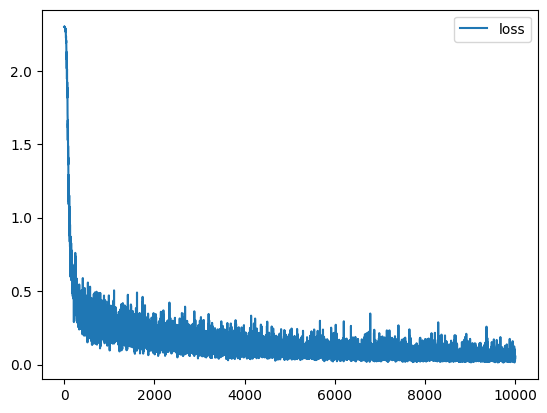

In [18]:
# 下面进行学习算法的应用，测试一下速度
import matplotlib.pyplot as plt

# 读入数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 重新生成神经网络
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10)

# 设置超参数
iters_nums = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 记录学习过程中的损失函数变化
train_loss_list = []

# 开始训练
for i in range(iters_nums):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 计算梯度
    grads = network.gradient(x_batch,t_batch)

    # 更新参数
    for key in grads.keys():
        network.params[key] -= learning_rate*grads[key]

    # 记录学习过程
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    # print(f"{i+1}th finish!")

x_list = np.arange(1,iters_nums+1,1)
plt.plot(x_list,train_loss_list,label = 'loss')
plt.legend()
plt.show()

# 速度随着迭代次数增加，与数值微分的差异呈现指数倍增长

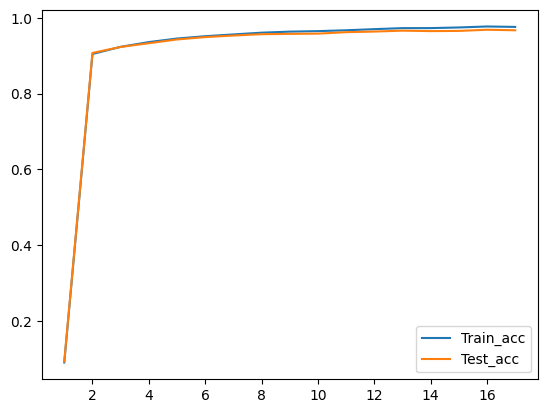

In [8]:
# 进行过拟合情况判断
import matplotlib.pyplot as plt
# 重新加载数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 重新生成神经网络
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10)

# 设置超参数
iters_nums = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(int(train_size/batch_size),1)

# 记录学习过程中的数据
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 开始学习
for i in range(iters_nums):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_bacth = t_train[batch_mask]

    # 计算梯度
    grads = network.gradient(x_batch,t_bacth)

    # 更新参数
    for key in grads.keys():
        network.params[key] -= learning_rate*grads[key]

    # 每个epoch进行一次准确度评估
    if (i%iter_per_epoch == 0):
        train_acc_list.append(network.accuracy(x_train,t_train))
        test_acc_list.append(network.accuracy(x_test,t_test))

x_list = np.arange(1,len(train_acc_list)+1,1)
plt.plot(x_list,train_acc_list,label = 'Train_acc')
plt.plot(x_list,test_acc_list,label = 'Test_acc')
plt.legend()
plt.show()    

# 拟合情况良好，没有发生过拟合

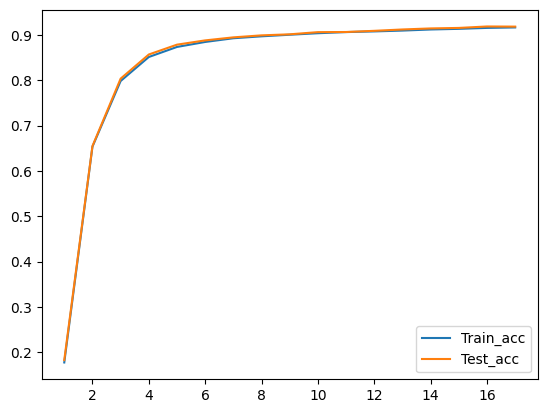

In [7]:
import matplotlib.pyplot as plt
# 封装SGD测试
# 将SGD进行类封装
class SGD:
    """随机梯度下降算法"""
    def __init__(self,learning_rate = 0.01):
        self.lr = learning_rate

    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

# 重新加载数据集
(x_train,t_train),(x_test,t_test) = load_mnist(flatten = True,one_hot_label = True)

# 重新生成神经网络
network = TwoLayerNet(input_size = 784,hidden_size = 50,output_size = 10)

# 设置超参数
iters_nums = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(int(train_size/batch_size),1)

# 记录学习过程中的数据
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 定义优化器，即优化方法：SGD
optimizer = SGD()

# 开始学习
for i in range(iters_nums):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_bacth = t_train[batch_mask]

    # 计算梯度
    grads = network.gradient(x_batch,t_bacth)
    params = network.params

    # 采用SGD更新参数
    optimizer.update(params,grads)
    
    # 每个epoch进行一次准确度评估
    if (i%iter_per_epoch == 0):
        train_acc_list.append(network.accuracy(x_train,t_train))
        test_acc_list.append(network.accuracy(x_test,t_test))

x_list = np.arange(1,len(train_acc_list)+1,1)
plt.plot(x_list,train_acc_list,label = 'Train_acc')
plt.plot(x_list,test_acc_list,label = 'Test_acc')
plt.legend()
plt.show()    

# 拟合情况良好，没有发生过拟合